# Calculating partition coefficients in plagioclase using various models
Jordan Lubbers <br>
Alaska Volcano Observatory

Here we explore how to calculate partition coefficients in plagioclase using the partitioning model of [Dohmen and Blundy (2014)](https://www.ajsonline.org/content/314/9/1319.short). We later then compare those results to:

1. [Bindeman et al., (1998)](https://www.sciencedirect.com/science/article/pii/S0016703798000477)
2. [Nielsen et al., (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017GC007080)
3. [Mutch et al., (2022)](https://www.sciencedirect.com/science/article/pii/S0016703722005841)

All these functions can be easily accessed in the `plag_diff` module using the following functions:
1. `plag_kd_calc`
2. `dohmen_kd_calc`
3. `mutch_kd_calc`
4. `dohmen_activity_calc`



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mendeleev
import statsmodels.api as sm


import sys
sys.path.append(
    r"C:\Users\jlubbers\OneDrive - DOI\Research\Coding\diffusion_chronometry")
import plag_diff as plag
sys.path.append(
    r"C:\Users\jlubbers\OneDrive - DOI\Research\Coding\QuatResearch23_tephra_classification")
# custom plotting defaults
import mpl_defaults

export_path = r"C:\Users\jlubbers\Desktop\test_figures"

## Building the functions

In [2]:
def dohmen_kd_calc_lepr(element, An, sio2_melt, temp):


    T_K = temp + 273.15  # K
    R = 8.314  # J/molK

    #calculate partition coefficients of Ca and Na based on LEPR database
    #these are equations 28a-b
    Kp_ca = np.exp((-19107 + 467 * sio2_melt) / (R * T_K))
    Kp_na = np.exp((13621 - 18990 * An) / (R * T_K))

    #Eq 27 for La partition coefficient based on Ca and Na
    Kp_la = Kp_ca**2 / Kp_na * np.exp((4400 - 30.8 * T_K) / (R * T_K))

    # get the ionic radius for 8 fold coordination and +1 charge
    if element in ["Li", "Na", "K", "Rb", "Cs"]:
        for i in mendeleev.element("Na").ionic_radii:
            if (i.coordination == "VIII") and (i.charge == 1):
                r_ref = i.ionic_radius / 100  # convert from pm to Angstroms

        for i in mendeleev.element(element).ionic_radii:
            if (i.coordination == "VIII") and (i.charge == 1):
                r_i = i.ionic_radius / 100  # convert from pm to Angstroms

        #Eq 19a for +1 charge
        r_m = 1.237 + -0.0171 * An
        #Eq 19b for +1 charge
        E_m = 49.05 + 17.16 * An

        #this is just so we can use the same general form for the Kd calc at the end
        Kp = Kp_na

    # get the ionic radius for 8 fold coordination and +2 charge
    elif element in ["Mg", "Ca", "Sr", "Ba"]:
        for i in mendeleev.element("Ca").ionic_radii:
            if (i.coordination == "VIII") and (i.charge == 2):
                r_ref = i.ionic_radius / 100  # convert from pm to Angstroms

        for i in mendeleev.element(element).ionic_radii:
            if (i.coordination == "VIII") and (i.charge == 2):
                r_i = i.ionic_radius / 100  # convert from pm to Angstroms

        # Eq 19b for +2 charge
        E_m = 120.0382 + -0.3686 * An
        # Eq 22 which is a modification of Eq 19 for the +2 cations
        r_m = 1.2895 + 0.00013 * (T_K - 1563) + (-0.0952 + -0.00004 * (T_K - 1563)) * An

        # this is just so we can use the same general form at the end
        Kp = Kp_ca

    elif element in [
        "Y",
        "La",
        "Ce",
        "Pr",
        "Nd",
        "Sm",
        "Eu",
        "Gd",
        "Tb",
        "Dy",
        "Ho",
        "Er",
        "Tm",
        "Yb",
        "Lu",
    ]:
        # get the ionic radius for 8 fold coordination and +3 charge
        for i in mendeleev.element("La").ionic_radii:
            if (i.coordination == "VIII") and (i.charge == 3):
                r_ref = i.ionic_radius / 100  # convert from pm to Angstroms

        for i in mendeleev.element(element).ionic_radii:
            if (i.coordination == "VIII") and (i.charge == 3):
                r_i = i.ionic_radius / 100  # convert from pm to Angstroms

        #Eq 19a for +3 charge
        r_m = 1.331 + -0.068 * An
        #Eq 19b for +3 charge
        E_m = 152 + -31 * An

        # this is just so we can use the same general form at the end
        Kp = Kp_la

    # General form for Eqs 18a-c based on the customized parameters in the conditional
    # statements above for different cation charges.
    dohmen_kd = Kp * np.exp(-910.17 * E_m / T_K * (r_m / 2 * (r_ref**2 - r_i**2) - 1 / 3 * (r_ref**3 - r_i**3)))
    dohmen_rtlnk = R * T_K * np.log(dohmen_kd) / 1000


    return dohmen_kd, dohmen_rtlnk



def dohmen_kd_calc(element, An, sio2_melt, temp):
    """calculate the partition coefficient of either Sr, Mg, or Ba
            in plagioclase according to the thermodynamic model outlined in
            Dohmen and Blundy (2014) doi: 10.2475/09.2014.04

            where partition coefficients for Ca and Na are derived from 
            using the LEPR database (Eqs 28a-b). 

            Will also calculate A and B parameters required for modeling
            diffusion of Sr and Mg as outlined in Costa et al. (2003)
            doi: 10.1016/S0016-7037(02)01345-5 which is effectively
            a regression of RTln(Kd) vs X_An where A is the slope
            and B is the intercept. 


    Args:
        element (str): element to calculate partition coefficient for

        An (array-like): fraction anorthite content of the plagioclase (X_an)

        sio2_melt (array-like): SiO2 wt% composition of the melt

        temp (array-like): temperature in degrees C

    Returns:
        dohmen_kd : partition coefficient
        dohmen_rtlnk : RTln(dohmen_k) in kJ/mol
        A : slope of regression in dohmen_rtlnk vs X_an space
        B : intercept of regression in dohmen_rtlnk vs X_an space
    """
    dohmen_kd, dohmen_rtlnk = dohmen_kd_calc_lepr(element = element, An = An, sio2_melt = sio2_melt, temp = temp)
    x_an = np.linspace(0,1,101)
    x = x_an.copy()
    x = sm.add_constant(x)
    model = sm.OLS(dohmen_kd_calc_lepr(element = element, An = x_an, sio2_melt = sio2_melt, temp = temp)[1],x)
    result = model.fit()
    B,A = result.params

    return dohmen_kd,dohmen_rtlnk,A,B


def plag_activity_calc(element,Xan, temp):
    """
    calculate the activity coefficient according to Dohment and Blundy (2014)
    This uses the equations 31 - 34 in that paper

    CURRENTLY THIS ONLY SUPPORTS THE +2 CATIONS: "Mg", "Ca", "Sr", "Ba", "Zn"

    Args:
        element (str): element for which the activity coefficient will be calculated
        Xan (scalar or array): molar fraction An (between 0 and 1)
        temp (scalar): temperature in degrees Celsius

    Returns:
        RTlngamma (array): RTln(activity coefficient) value in kJ/mol for the element specified
        gamma (array): activity coefficient value in J/mol for the element specified


    """

    T_K = temp + 273.15
    x_an_ci = 0.12 + 0.00038 * T_K


    if np.isscalar(Xan) is True:
        Xan = np.array(Xan)
    
    if element in ["Mg", "Ca", "Sr", "Ba", "Zn"]:
        for i in mendeleev.element("Ca").ionic_radii:
            if (i.coordination == "VIII") and (i.charge == 2):
                r_ref = i.ionic_radius / 100  # convert from pm to Angstroms

        for i in mendeleev.element(element).ionic_radii:
            if (i.coordination == "VIII") and (i.charge == 2):
                r_i = i.ionic_radius / 100  # convert from pm to Angstroms

        E_m = 120.03824
        # Eq 22 which is a modification of Eq 19 for the +2 cations
        # r_m = 1.2895 + 0.00013 * (T_K - 1563) + (-0.0952 + -0.00004 * (T_K - 1563)) * x_an

        # r_oab = 1.2895
        r_oab = 1.2778
        i_an = -(-4 - 0) * (1 - x_an_ci) ** 2
        i_an = np.full(Xan.shape, i_an)
        i_an[Xan > x_an_ci] = 0

        w_aban = np.full(Xan.shape, -4)
        w_aban[Xan > x_an_ci] = 0

        # a2 = -0.0952
        a2 = -0.0916


        b2 = -0.3686

        a = (
            -910.17
            * 8.314
            * E_m
            * (r_oab / 2 * (r_ref**2 - r_i**2) - 1 / 3 * (r_ref**3 - r_i**3))
            / 1000
            - w_aban
            - i_an
        )

        b = (
            -910.17
            * 8.314
            * (
                (E_m * a2 / 2 + r_oab / 2 * b2) * (r_ref**2 - r_i**2)
                - b2 / 3 * (r_ref**3 - r_i**3)
            )
            / 1000
            + 2 * w_aban
        )

        c = -w_aban - 910.17 * 8.314 * a2 * b2 / 2 * (r_ref**2 - r_i**2) / 1000

        RTlngamma = a + b * Xan + c * Xan**2

        

        return RTlngamma, np.exp(RTlngamma*1000/(8.314*T_K))



def dohmen_activity_calc(element,Xan, temp,return_regression_stats = False):
    """
    calculate the activity coefficient according to Dohment and Blundy (2014)
    This uses the equations 31 - 34 in that paper

    Args:
        element (str): element for which the activity coefficient will be calculated
        Xan (scalar or array): molar fraction An (between 0 and 1)
        temp (scalar): temperature in degrees Celsius

    Returns:
        RTlngamma (scalar or array): RTln(activity coefficient) value in kJ/mol for the element specified
        gamma (scalar or array): activity coefficient value in J/mol for the element specified
        slope (scalar): slope of regression in RTln(activity coefficient) vs Xan space
        intercept (scalar): intercept of regression in RTln(activity coefficient) vs Xan space
    """
    RTlngamma, gamma = plag_activity_calc(element, Xan, temp)
    x = np.linspace(0,1,101)
    X = sm.add_constant(x)
    model = sm.OLS(plag_activity_calc(element, x,temp)[0],X)
    result = model.fit()
    intercept,slope = result.params

    if return_regression_stats is True:


        return RTlngamma, gamma, slope, intercept, result
    else:

        return RTlngamma, gamma, slope, intercept

    


## Comparing different partitioning models

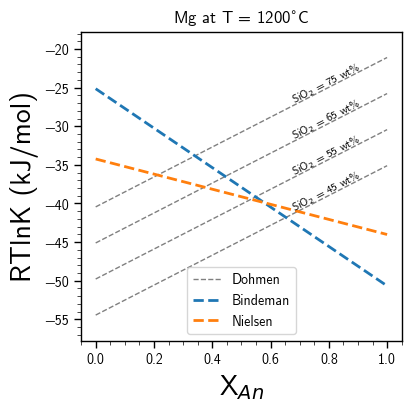

In [3]:
element = "Mg"
T = 1200
x_an = np.linspace(0, 1, 11)

bindeman_kd, bindeman_std, bindeman_A, bindeman_B = plag.plag_kd_calc(
    element=element, An=x_an, temp=T + 273, method="Bindeman"
)
nielsen_kd, nielsen_std, nielsen_A, nielsen_B = plag.plag_kd_calc(
    element=element, An=x_an, temp=T + 273, method="Nielsen"
)

bindeman_rtlnk = np.log(bindeman_kd) * 8.314 * (T + 273) / 1000
nielsen_rtlnk = np.log(nielsen_kd) * 8.314 * (T + 273) / 1000


fig, ax = plt.subplots(figsize=(4, 4), layout="constrained")


for sio2 in [45, 55, 65, 75]:
    if sio2 == 45:
        (l,) = ax.plot(
            x_an,
            dohmen_kd_calc(element, An=x_an, sio2_melt=sio2, temp=T)[1],
            c="gray",
            ls="--",
            lw=1,
            label="Dohmen",
        )
    else:
        (l,) = ax.plot(
            x_an,
            dohmen_kd_calc(element, An=x_an, sio2_melt=sio2, temp=T)[1],
            c="gray",
            ls="--",
            lw=1,
        )

    mpl_defaults.line_annotate(
        f"SiO$_2$ = {sio2} wt%",
        l,
        0.8,
        xytext=(0, 2),
        textcoords="offset pixels",
        fontsize=8,
    )

ax.plot(x_an, bindeman_rtlnk, ls="--", label="Bindeman", lw=2)
ax.plot(x_an, nielsen_rtlnk, ls="--", label="Nielsen", lw=2)

ax.legend(loc="lower center")
ax.set_ylabel("RTlnK (kJ/mol)")


ax.set_title(f"{element} at T = {T}$^{{\circ}}$C")


# ax.set_ylim(-60,-10)
ax.set_xlabel("X$_{An}$")

plt.savefig(f"{export_path}\dohmen_kd_calc_options_{element}_compare.png",bbox_inches = 'tight')
plt.savefig(f"{export_path}\dohmen_kd_calc_options_{element}_compare.pdf",bbox_inches = 'tight')

## adding in the Mutch model for Mg

In [4]:
help(plag.mutch_kd_calc)

Help on function mutch_kd_calc in module plag_diff:

mutch_kd_calc(An, temp, sio2_melt)
    Calculate the partition coefficient for Mg in plagioclase
        according to Mutch et al 2022 doi: 10.1016/j.gca.2022.10.035
    
    Args:
        An (array-like): fraction anorthite content of the plagioclase (X_an)
    
        sio2_melt (array-like): SiO2 wt% composition of the melt
    
        temp (array-like): temperature in degrees C
    
    Returns:
        kd_mutch : partition coefficient for Mg in plagioclase
        rtlnk_mutch : RTln(kd_mutch) in kj/mol
        x_an_dev : X_An - X_C1I1...the difference between the observed
        anorthite value and the anorthite value of the C1-I1 transition
        at the given temperature.



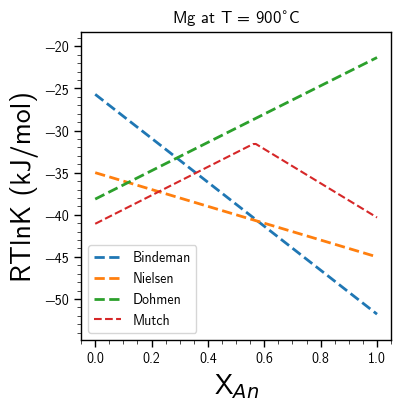

In [5]:
element = "Mg"
T = 900
x_an = np.linspace(0, 1, 101)
sio2_melt = 62.4

fig, ax = plt.subplots(figsize = (4,4))

for method in ["Bindeman", "Nielsen", "Dohmen"]:
    kd, rtlnk, A, B = plag.plag_kd_calc(element=element, An=x_an, temp=T, sio2_melt=sio2_melt, method=method)

    ax.plot(x_an, rtlnk, ls="--", lw=2, label=method)

if element == 'Mg':
    ax.plot(x_an, plag.mutch_kd_calc(An = x_an, sio2_melt = sio2_melt, temp = T)[1],ls = '--',label = 'Mutch')
    
ax.legend(loc="lower left")
ax.set_ylabel("RTlnK (kJ/mol)")


ax.set_title(f"{element} at T = {T}$^{{\circ}}$C")


# ax.set_ylim(-60,-10)
ax.set_xlabel("X$_{An}$")
plt.savefig(f"{export_path}/{element}_plag_rtlnkd_comparison.png",bbox_inches = 'tight')

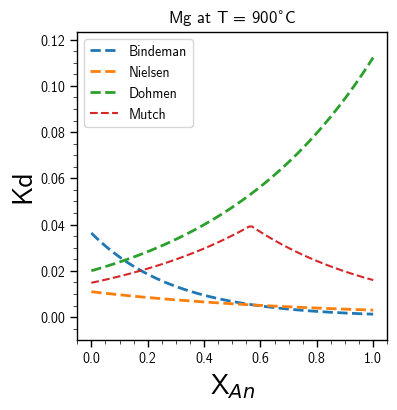

In [6]:
T = 900
x_an = np.linspace(0, 1, 101)
sio2_melt = 62.4

fig, ax = plt.subplots(figsize = (4,4))

for method in ["Bindeman", "Nielsen", "Dohmen"]:
    kd, rtlnk, A, B = plag.plag_kd_calc(element=element, An=x_an, temp=T, sio2_melt=sio2_melt, method=method)

    ax.plot(x_an, kd, ls="--", lw=2, label=method)

if element == 'Mg':
    ax.plot(x_an, plag.mutch_kd_calc(An = x_an, sio2_melt = sio2_melt, temp = T)[0],ls = '--',label = 'Mutch')
    
ax.legend(loc="upper left")
ax.set_ylabel("Kd")


ax.set_title(f"{element} at T = {T}$^{{\circ}}$C")


# ax.set_ylim(-60,-10)
ax.set_xlabel("X$_{An}$")
plt.savefig(f"{export_path}/{element}_plag_kd_comparison.png",bbox_inches = 'tight')

## Showing that the above equations do the same as the functions in the `plag_diff` module

You can use the `plag.dohmen_kd_calc` on its own or it also gets used in the `plag.plag_kd_calc` function if you specify `method = "Dohmen"`

In [7]:
help(plag.dohmen_kd_calc)

Help on function dohmen_kd_calc in module plag_diff:

dohmen_kd_calc(element, An, sio2_melt, temp)
    calculate the partition coefficient of either Sr, Mg, or Ba
            in plagioclase according to the thermodynamic model outlined in
            Dohmen and Blundy (2014) doi: 10.2475/09.2014.04
    
            where partition coefficients for Ca and Na are derived from
            using the LEPR database (Eqs 28a-b).
    
            Will also calculate A and B parameters required for modeling
            diffusion of Sr and Mg as outlined in Costa et al. (2003)
            doi: 10.1016/S0016-7037(02)01345-5 which is effectively
            a regression of RTln(Kd) vs X_An where A is the slope
            and B is the intercept.
    
    
    Args:
        element (str): element to calculate partition coefficient for
    
        An (array-like): fraction anorthite content of the plagioclase (X_an)
    
        sio2_melt (array-like): SiO2 wt% composition of the melt
    
        

In [8]:
print("element :  Kd")
print("-----------------------------")
for element in (
    ["Li", "Na", "K", "Rb", "Cs"]
    + ["Mg", "Ca", "Sr", "Ba"]
    + ["Y","La","Ce","Pr","Nd","Sm","Eu","Gd", "Tb","Dy","Ho","Er","Tm","Yb","Lu",]
):
    dohmen_kd, dohmen_rtlnk, A, B = plag.dohmen_kd_calc(
        element=element, An=0.4, sio2_melt=62.4, temp=1200
    )
    print(f"{element}      : Kd = {np.round(dohmen_kd,4)} : A = {np.round(A,2)}")
    

element :  Kd
-----------------------------
Li      : Kd = 0.3146 : A = -23.09
Na      : Kd = 1.6355 : A = -18.99
K      : Kd = 0.2535 : A = -29.41
Rb      : Kd = 0.0427 : A = -37.3
Cs      : Kd = 0.0015 : A = -51.57
Mg      : Kd = 0.0429 : A = 19.35
Ca      : Kd = 2.2688 : A = -0.0
Sr      : Kd = 4.1948 : A = -13.86
Ba      : Kd = 0.8514 : A = -31.61
Y      : Kd = 0.0066 : A = 37.2
La      : Kd = 0.1109 : A = 18.99
Ce      : Kd = 0.0858 : A = 21.03
Pr      : Kd = 0.0647 : A = 23.12
Nd      : Kd = 0.0477 : A = 25.26
Sm      : Kd = 0.0263 : A = 29.12
Eu      : Kd = 0.0199 : A = 30.84
Gd      : Kd = 0.0149 : A = 32.57
Tb      : Kd = 0.011 : A = 34.33
Dy      : Kd = 0.0081 : A = 36.1
Ho      : Kd = 0.006 : A = 37.76
Er      : Kd = 0.0045 : A = 39.28
Tm      : Kd = 0.0035 : A = 40.68
Yb      : Kd = 0.0027 : A = 41.95
Lu      : Kd = 0.0022 : A = 43.09


In [9]:
help(plag.plag_kd_calc)

Help on function plag_kd_calc in module plag_diff:

plag_kd_calc(element, An, temp, method, sio2_melt=60)
    calculates the partition coefficient for a given element in plagioclase based on its anorthite
    content according to the Arrhenius relationship as originally defined by Blundy and Wood (1991)
    
    This function gives the user an option of three experimental papers to choose from when calculating
    partition coefficient:
    
    Bindeman et al., 1998 = ['Li','Be','B','F','Na','Mg','Al','Si','P','Cl','K','Ca','Sc',
    'Ti','Cr','Fe','Co','Rb','Sr','Zr','Ba','Y','La','Ce','Pr','Nd','Sm','Eu','Pb']
    
    Nielsen et al., 2017 = ['Mg','Ti','Sr','Y','Zr','Ba','La','Ce','Pr','Nd','Pb']
    
    Tepley et al., 2010 = ['Sr','Rb','Ba','Pb','La','Nd','Sm','Zr','Th','Ti']
    
    Dohmen and Blundy (2014) = ["Li", "Na", "K", "Rb", "Cs","Mg",
                                 "Ca", "Sr", "Ba","Y","La","Ce","Pr",
                                 "Nd","Sm","Eu","Gd","Tb","Dy","Ho"

In [10]:
print("element :  Kd")
print("-----------------------------")
for element in (
    ["Li", "Na", "K", "Rb", "Cs"]
    + ["Mg", "Ca", "Sr", "Ba"]
    + ["Y","La","Ce","Pr","Nd","Sm","Eu","Gd", "Tb","Dy","Ho","Er","Tm","Yb","Lu",]
):
    dohmen_kd, dohmen_rtlnk, A, B = plag.plag_kd_calc(
        element=element, An=0.4,temp=1200, method = "Dohmen",sio2_melt=62.4, 
    )
    print(f"{element}      : Kd = {np.round(dohmen_kd,4)} : A = {np.round(A,2)}")

element :  Kd
-----------------------------
Li      : Kd = 0.3146 : A = -23.09
Na      : Kd = 1.6355 : A = -18.99
K      : Kd = 0.2535 : A = -29.41
Rb      : Kd = 0.0427 : A = -37.3
Cs      : Kd = 0.0015 : A = -51.57
Mg      : Kd = 0.0429 : A = 19.35
Ca      : Kd = 2.2688 : A = -0.0
Sr      : Kd = 4.1948 : A = -13.86
Ba      : Kd = 0.8514 : A = -31.61
Y      : Kd = 0.0066 : A = 37.2
La      : Kd = 0.1109 : A = 18.99
Ce      : Kd = 0.0858 : A = 21.03
Pr      : Kd = 0.0647 : A = 23.12
Nd      : Kd = 0.0477 : A = 25.26
Sm      : Kd = 0.0263 : A = 29.12
Eu      : Kd = 0.0199 : A = 30.84
Gd      : Kd = 0.0149 : A = 32.57
Tb      : Kd = 0.011 : A = 34.33
Dy      : Kd = 0.0081 : A = 36.1
Ho      : Kd = 0.006 : A = 37.76
Er      : Kd = 0.0045 : A = 39.28
Tm      : Kd = 0.0035 : A = 40.68
Yb      : Kd = 0.0027 : A = 41.95
Lu      : Kd = 0.0022 : A = 43.09


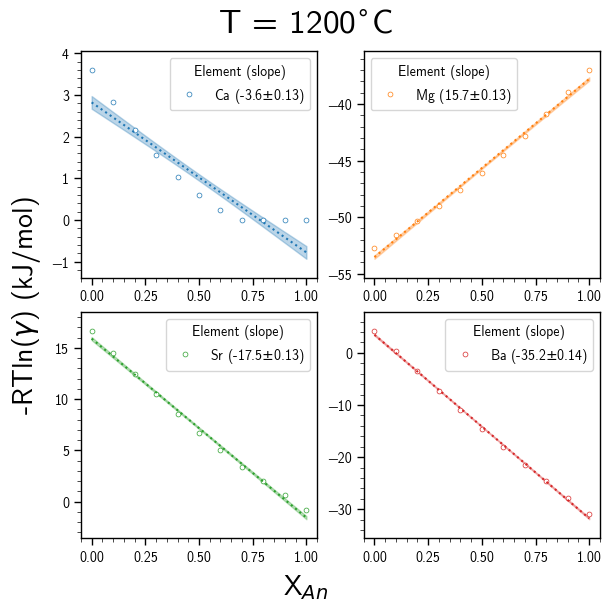

In [11]:
T = 1200
T_K = T + 273.15
x_an = np.linspace(0, 1, 101)

elements = ["Ca", "Mg", "Sr", "Ba"]
colors = ["C0", "C1", "C2", "C3"]

fig, ax = plt.subplots(2, 2, figsize=(6, 6), layout="constrained")
axes = ax.ravel()
for element, color, a in zip(elements, colors, axes):
    RTlngamma, gamma, slope, intercept, stats = dohmen_activity_calc(
        element=element, Xan=x_an, temp=T, return_regression_stats=True
    )
    regression_df = stats.get_prediction().summary_frame()
    a.plot(
        x_an,
        RTlngamma,
        marker=".",
        ls = "",
        mfc="white",
        mec=color,
        markevery=10,
        label=f"{element} ({np.round(slope,1)}$\pm${np.round(stats.bse[1],2)})",
    )
    a.plot(x_an, x_an * slope + intercept, color=color, ls=":")
    a.fill_between(
        x_an,
        regression_df["mean_ci_lower"],
        regression_df["mean_ci_upper"],
        color=color,
        alpha=0.3,
    )

    a.legend(title="Element (slope)")
fig.supxlabel("X$_{An}$",fontsize = 20)
fig.supylabel("-RTln($\gamma$) (kJ/mol)",fontsize = 20)
fig.suptitle(f"T = {T}$^{{\circ}}$C")
plt.savefig(f"{export_path}\dohmen_gamma_calc.png",bbox_inches = 'tight')


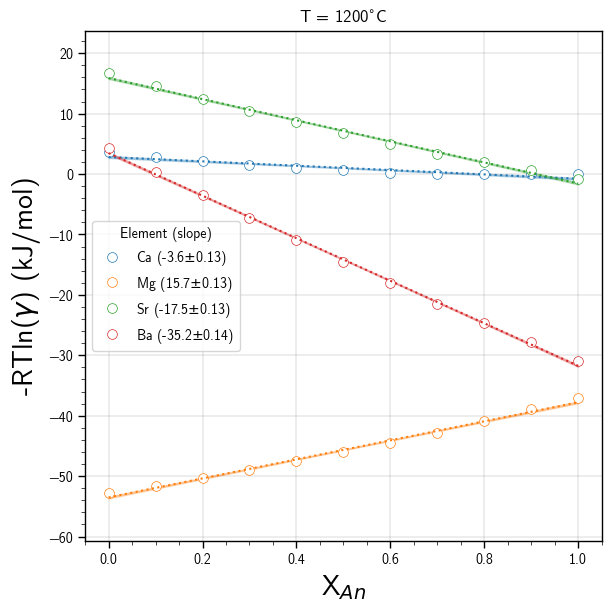

In [12]:
T = 1200
T_K = T + 273.15
x_an = np.linspace(0, 1, 101)

elements = ["Ca", "Mg", "Sr", "Ba"]
colors = ["C0", "C1", "C2", "C3"]

fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")
for element, color, a in zip(elements, colors, axes):
    RTlngamma, gamma, slope, intercept, stats = dohmen_activity_calc(
        element=element, Xan=x_an, temp=T, return_regression_stats=True
    )
    regression_df = stats.get_prediction().summary_frame()
    ax.plot(
        x_an,
        RTlngamma,
        marker="o",
        ls = "",
        mfc="white",
        mec=color,
        markevery=10,
        label=f"{element} ({np.round(slope,1)}$\pm${np.round(stats.bse[1],2)})",
    )
    ax.plot(x_an, x_an * slope + intercept, color=color, ls=":")
    ax.fill_between(
        x_an,
        regression_df["mean_ci_lower"],
        regression_df["mean_ci_upper"],
        color=color,
        alpha=0.3,
    )

    ax.legend(title="Element (slope)")
ax.set_xlabel("X$_{An}$",fontsize = 20)
ax.set_ylabel("-RTln($\gamma$) (kJ/mol)",fontsize = 20)
ax.set_title(f"T = {T}$^{{\circ}}$C")
ax.grid()
fig.set_facecolor('w')
plt.savefig(f"{export_path}\dohmenetal2017_figA1_recreated.png",bbox_inches = 'tight')
